# Homework 4 | PSTAT 134 | Natural Language Processing
____

## Natural Langauge Processing
We'll work with the data in data/spotify-review-data.csv. This CSV file contains a total of 51,473 rows, each representing a unique user review for the Spotify application. The dataset has two columns:
- Review: This column contains the text of user reviews, reflecting their experiences, opinions, and feedback on the Spotify app.
- Sentiment label: This column categorizes each review as either "POSITIVE" or "NEGATIVE" based on its sentiment.

The data comes from this source at Kaggle:
[https://www.kaggle.com/datasets/alexandrakim2201/spotify-dataset](https://www.kaggle.com/datasets/alexandrakim2201/spotify-dataset)

In [935]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

import math
import string
import re
import nltk
import contractions

from itertools import islice
from collections import Counter
from collections import defaultdict
from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import VarianceThreshold

### Exercise 1
Read the data into Python.

Take a look at the distribution of label. Are there relatively even numbers of negative and positive reviews in the data set?

In [5]:
data = pd.read_csv("data/spotify-review-data.csv")
print(data)

                                                  Review     label
0      Great music service, the audio is high quality...  POSITIVE
1      Please ignore previous negative rating. This a...  POSITIVE
2      This pop-up "Get the best Spotify experience o...  NEGATIVE
3        Really buggy and terrible to use as of recently  NEGATIVE
4      Dear Spotify why do I get songs that I didn't ...  NEGATIVE
...                                                  ...       ...
52697                                       Yes the best  POSITIVE
52698  Spotify won my heart in Feb 2024 You won my he...  POSITIVE
52699  I tried to open the app and it wont open I res...  POSITIVE
52700                                              Good   POSITIVE
52701  Nice app to play music and at very affordable ...  POSITIVE

[52702 rows x 2 columns]


In [6]:
missing_values = data.isnull().sum()
print("Missing values in each column:\n", missing_values)

Missing values in each column:
 Review    16
label      0
dtype: int64


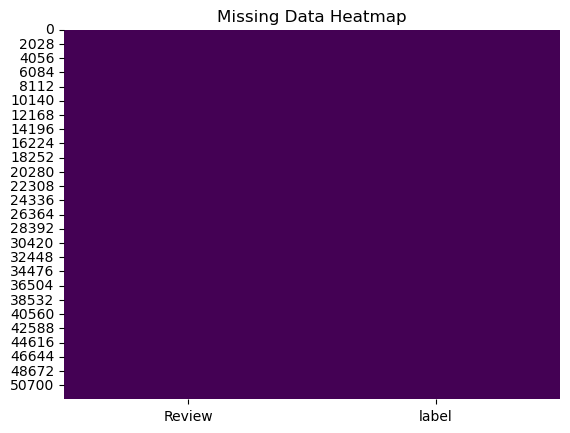

In [7]:
#viz missing data
sns.heatmap(data.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap');

NEGATIVE    29423
POSITIVE    23279
Name: label, dtype: int64


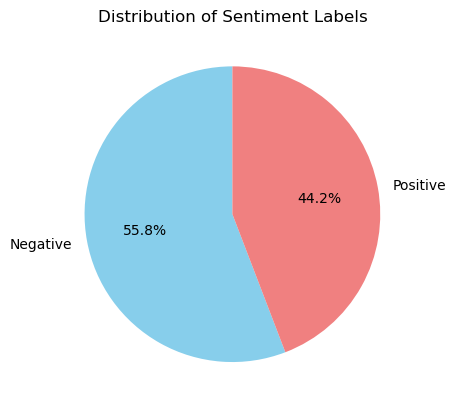

In [8]:
label_counts = data['label'].value_counts();

print(label_counts)

label_counts.plot(kind='pie', 
                  autopct='%1.1f%%', 
                  startangle=90, 
                  colors=['skyblue', 'lightcoral'], 
                  labels=['Negative', 'Positive']);

plt.title('Distribution of Sentiment Labels'), plt.ylabel('');

> Based on the numeric counts and pie chart, we see that there tends to be a more negative sentiment within the dataset. There are 29,423 reviews that are labelled "negative", while there are 23,279 reviews that are "positive". Distribution-wise, this reflects a 55.8% to 44.2% distribution of negative to positive reviews.

### Exercise 2
Take a random sample of 10,000 reviews, stratified by label. All further exercises will be working with this smaller sample of reviews.

In [902]:
strat_data = train_test_split(data, stratify = data['label'], test_size = 10000, random_state = 3)
strat_data = strat_data[1]

In [904]:
strat_data

,Review,label
33050,"Usually love this app, but it seems like every...",NEGATIVE
22351,I've never experienced a musical roller-coaste...,POSITIVE
20426,I really enjoy using this app but ever since t...,NEGATIVE
21743,This app has become incredibly buggy of late. ...,NEGATIVE
19638,"After a update some time ago, the buttons on t...",NEGATIVE
...,...,...
21478,Love thus and all it wide rang of music and po...,POSITIVE
6224,If you listen to music this app for you lol,NEGATIVE
46626,I have been a spotify customer for +/- 15 yrs....,POSITIVE
47856,The only thing that I would appreciate is if t...,NEGATIVE


### Exercise 3
Tokenize the reviews into words.

Remove stop words. (You can use any pre-made list of stop words of your choice.)

Clean the reviews. Remove punctuation and convert the letters to lowercase.

Verify that this process worked correctly.

In [907]:
#function to expand contractions -> this will fix errors with words like can't where tokenization and function removal may leave words like 'nt' or 'ca'
def expand_contractions(text):
    return contractions.fix(text)

#convert to string values before tokenization
strat_data['Review'] = strat_data['Review'].astype(str)

#contraction expansion before tokenization
strat_data['Review'] = strat_data['Review'].apply(expand_contractions)

#ensure review column is in string format for tokenization
strat_data['tokenized'] = strat_data['Review'].apply(word_tokenize)

In [908]:
#remove stopwords that may not contribute much to meaning
stop_words = set(stopwords.words("english"))

#init punctuation for removal
sp = set(string.punctuation)

#function to traverse and return only words not in stopwords list
def remove_stopwords(tokens):
    return [word for word in tokens if word.lower() not in stop_words]

strat_data['tokenized'] = strat_data['tokenized'].apply(remove_stopwords)


In [909]:
#remove punctuation
def clean_tokens(tokens):
    return [
        re.sub(r'[^\w\s]', '', word).lower()
        for word in tokens
        if re.sub(r'[^\w\s]', '', word).isalpha()  
    ]

strat_data['clean_token'] = strat_data['tokenized'].apply(clean_tokens)

In [910]:
strat_data.head() #verify

,Review,label,tokenized,clean_token
33050,"Usually love this app, but it seems like every...",NEGATIVE,"[Usually, love, app, ,, seems, like, every, si...","[usually, love, app, seems, like, every, singl..."
22351,I have never experienced a musical roller-coas...,POSITIVE,"[never, experienced, musical, roller-coaster, ...","[never, experienced, musical, rollercoaster, l..."
20426,I really enjoy using this app but ever since t...,NEGATIVE,"[really, enjoy, using, app, ever, since, new, ...","[really, enjoy, using, app, ever, since, new, ..."
21743,This app has become incredibly buggy of late. ...,NEGATIVE,"[app, become, incredibly, buggy, late, ., try,...","[app, become, incredibly, buggy, late, try, op..."
19638,"After a update some time ago, the buttons on t...",NEGATIVE,"[update, time, ago, ,, buttons, notification, ...","[update, time, ago, buttons, notification, alw..."


### Exercise 4
Create a bar chart of the most commonly-occurring words (not including stop words).

Create bar charts of the most commonly-occurring words, broken down by label. What words are more common in positive reviews? What words are more common in negative reviews?

In [520]:
all_words = [word for tokens in strat_data['clean_token'] for word in tokens]

word_counts = Counter(all_words)

common_words = word_counts.most_common(15)

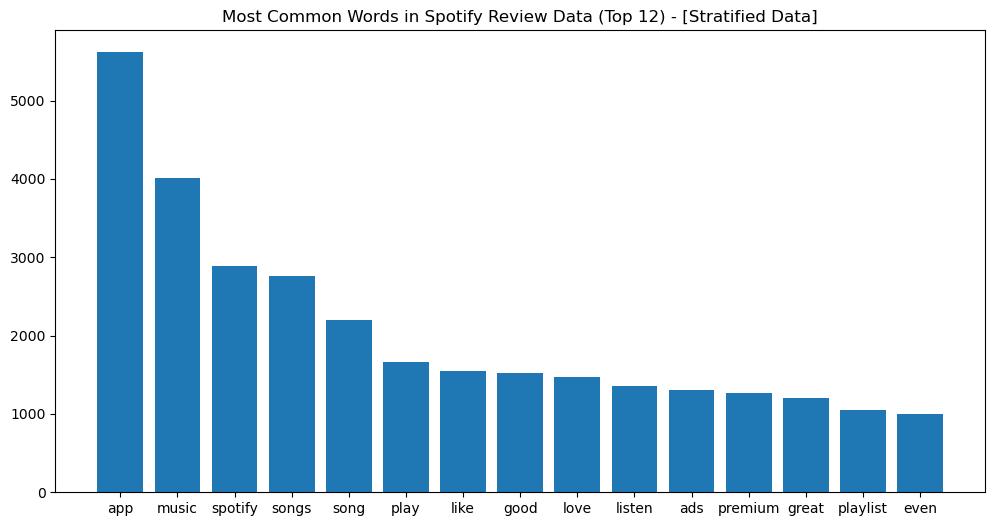

In [338]:
words, counts = zip(*common_words)
plt.figure(figsize = (12,6)), plt.title("Most Common Words in Spotify Review Data (Top 12) - [Stratified Data]")
plt.bar(words, counts);

In [345]:
#flatten for positive and negative reviews
positive_words = [word for tokens in strat_data[strat_data['label'] == 'POSITIVE']['clean_token'] for word in tokens]
negative_words = [word for tokens in strat_data[strat_data['label'] == 'NEGATIVE']['clean_token'] for word in tokens]

#get counts
positive_counts = Counter(positive_words).most_common(10)  
negative_counts = Counter(negative_words).most_common(10) 

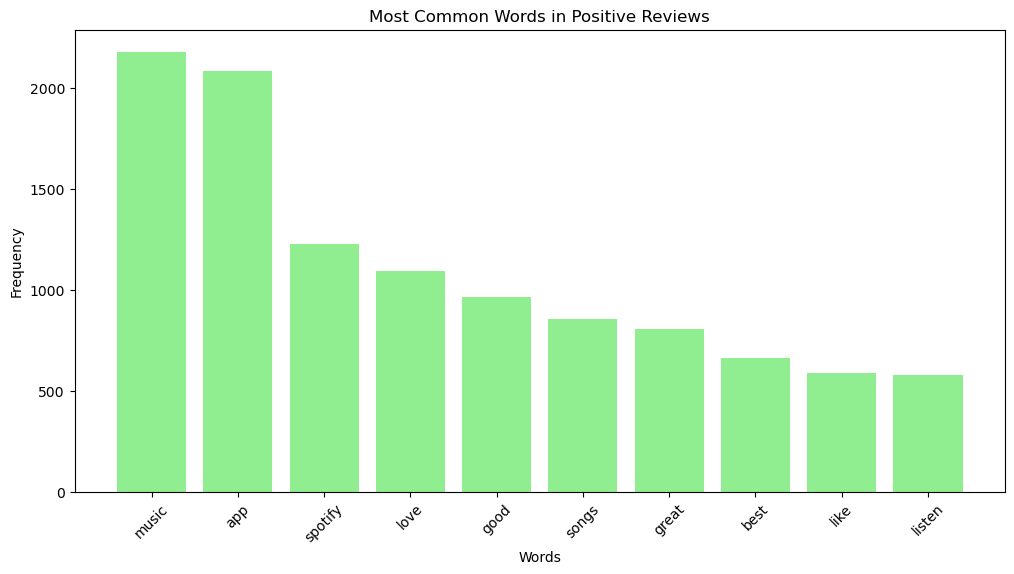

In [347]:
pos_words, pos_counts = zip(*positive_counts)
plt.figure(figsize=(12, 6))
plt.bar(pos_words, pos_counts, color='#90ee90')
plt.title('Most Common Words in Positive Reviews')
plt.xticks(rotation=45), plt.xlabel('Words'), plt.ylabel('Frequency');

> We see the most common words in a positive review include "music" and "app" but more common words that may be more indicative of the sentiment of a user would be words like "good", "great", "like", and "love".

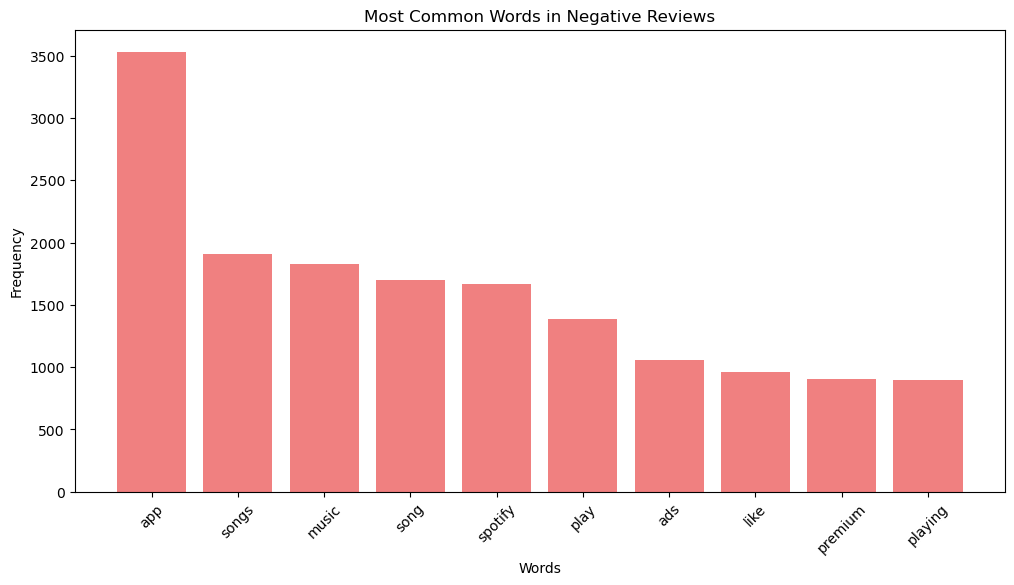

In [41]:
neg_words, neg_counts = zip(*negative_counts)
plt.figure(figsize=(12, 6))
plt.bar(neg_words, neg_counts, color='#f08080')
plt.title('Most Common Words in Negative Reviews')
plt.xticks(rotation=45), plt.xlabel('Words'), plt.ylabel('Frequency');

> Some common words in negative reviews include "app" and "songs" but some other common words that may be more indicative of a negative review may be words like "ads" and "premium".

### Exercise 5
Create a word cloud of the most commonly-occurring words overall, broken down by "positive" or "negative" sentiment (using the Bing sentiment lexicon).

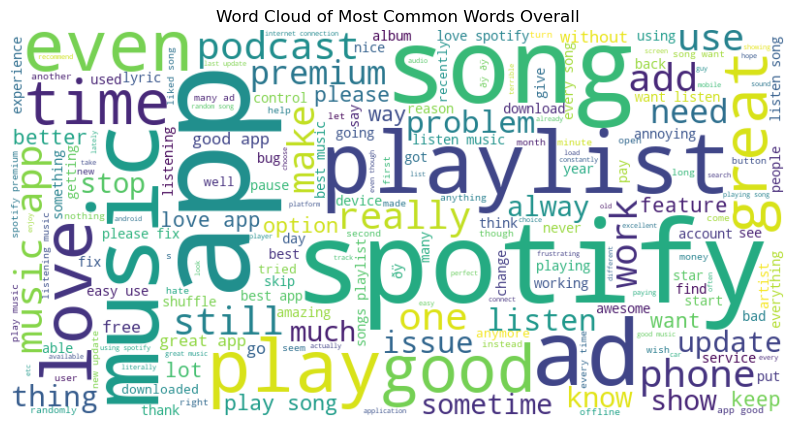

In [45]:
all_words = ' '.join([word for tokens in strat_data['clean_token'] for word in tokens])

#generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_words)

#plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off'), plt.title('Word Cloud of Most Common Words Overall'), plt.show();

In [46]:
positive_words = ' '.join([word for tokens in strat_data[strat_data['label'] == 'POSITIVE']['clean_token'] for word in tokens])
negative_words = ' '.join([word for tokens in strat_data[strat_data['label'] == 'NEGATIVE']['clean_token'] for word in tokens])

pos_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Greens').generate(positive_words)

neg_wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(negative_words)

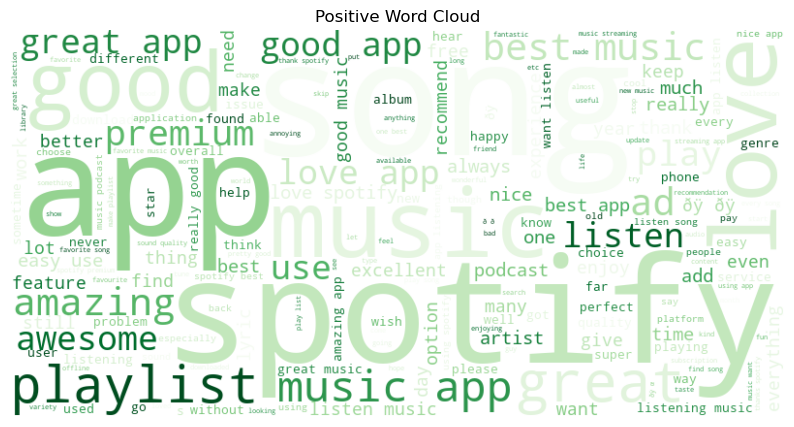

In [48]:
plt.figure(figsize=(10, 6))
plt.imshow(pos_wordcloud, interpolation='bilinear')
plt.axis('off'), plt.title('Positive Word Cloud');

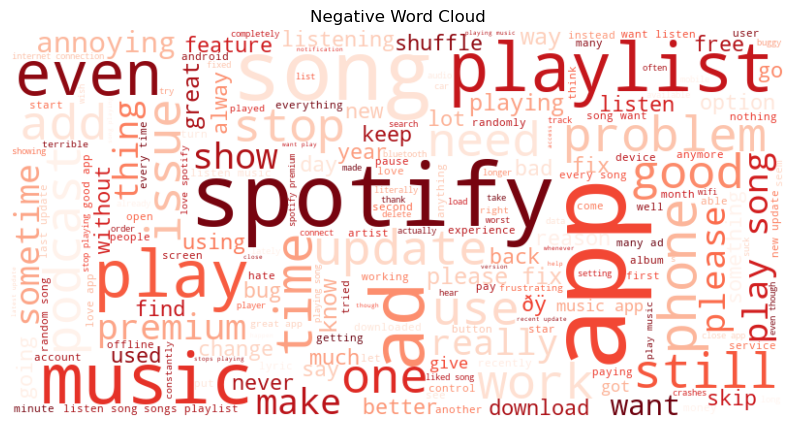

In [49]:
plt.figure(figsize=(10, 6))
plt.imshow(neg_wordcloud, interpolation='bilinear')
plt.axis('off'), plt.title('Negative Word Cloud');

### Exercise 6
Calculate the tf-idf values for the words in the dataset.
- Find the 30 words with the largest tf-idf values.
- Find the 30 words with the smallest tf-idf values.

> Since the exercise asks for the largest and smallest TF-IDF values, it seems to imply looking at:
> The largest and smallest individual TF-IDF scores for words across all documents:
> Flatten all document-specific TF-IDF scores into a single list.
> Then, find the largest and smallest TF-IDF scores across this list.
> This approach focuses on individual TF-IDF values rather than treating words as having one global score.

In [913]:
#convert the stratified and cleaned dataset into a dictionary of reviews for ease of tf-idf implementation
strat_data["Review_clean"] = strat_data["clean_token"].apply(lambda tokens: " ".join(tokens))
strat_data = strat_data.drop(columns=["Review", "tokenized", "clean_token"])
dataset = strat_data.to_dict(orient="records")

In [914]:
unwanted_char = ["ð", "œðÿ", "ðÿ", "žðÿ", "šð", "â", "âœ", "ÿ", "œ", "ž", "š"]

# Iterate through each dictionary in the dataset
for entry in dataset:
    # Ensure the value is a string
    if isinstance(entry["Review_clean"], str):
        # Clean the unwanted characters inline
        for pattern in unwanted_char:
            entry["Review_clean"] = entry["Review_clean"].replace(pattern, "")
dataset[0]

{'label': 'NEGATIVE',
 'Review_clean': 'usually love app seems like every single time try play song stops seconds music downloaded even happens every time go play music'}

In [917]:
#document frequency = # of documents that contain the term t
df = defaultdict(int)
for d in dataset:
    r = ''.join([c for c in d['Review_clean']])
    for w in set(r.split()):
        df[w] += 1

In [920]:
#idf - take the log base 10 of (#of documents / # of documents that contain that term)
idf = {}
for w, freq in df.items():
    idf[w] = math.log10(len(dataset) / freq)

In [923]:
tfidf_global = []
for d in dataset:
    tf = defaultdict(int)
    tfidf = defaultdict(int)
    r = ''.join([c for c in d['Review_clean']])
    for w in r.split():
        tf[w] += 1
    for w in tf:
        tfidf[w] = tf[w] * idf[w]
        tfidf_global.append((tfidf[w], w))

In [933]:
unique_tfidf = {}

for score, word in tfidf_global:
    if word not in unique_tfidf:
        unique_tfidf[word] = score 
    else:
        unique_tfidf[word] = max(unique_tfidf[word], score) 
unique_tfidf_list = [(score, word) for word, score in unique_tfidf.items()]

unique_tfidf_sorted = sorted(unique_tfidf_list, key=lambda x: x[0])
bottom_30 = unique_tfidf_sorted[:30]  
top_30 = unique_tfidf_sorted[-30:]  

print("Bottom 30 Unique Words by TF-IDF Score:")
for score, word in bottom_30:
    print(f"{word}: {score:.4f}")

print("\nTop 30 Unique Words by TF-IDF Score:")
for score, word in top_30:
    print(f"{word}: {score:.4f}")

Bottom 30 Unique Words by TF-IDF Score:
frustrating: 1.9136
stopping: 2.0362
point: 2.0362
least: 2.0410
ok: 2.0458
ago: 2.0506
bottom: 2.0605
unless: 2.0862
otherwise: 2.0915
uninstalled: 2.1024
loved: 2.1192
place: 2.1487
thought: 2.1487
around: 2.1549
reinstall: 2.1675
understand: 2.1805
enough: 2.1871
rating: 2.2007
press: 2.2076
gave: 2.2147
app: 2.2205
uninstalling: 2.2291
matter: 2.2366
reinstalled: 2.2366
broken: 2.2366
create: 2.2518
anyone: 2.2596
collection: 2.2676
worked: 2.2676
middle: 2.2676

Top 30 Unique Words by TF-IDF Score:
die: 10.1938
trial: 10.2745
l: 10.2745
kanye: 10.5686
hav: 10.5686
distortion: 10.5686
pls: 10.6247
track: 10.9023
hi: 10.9789
plan: 11.0734
cold: 11.0969
horror: 11.0969
transferring: 11.0969
line: 11.1835
ads: 11.2854
gaana: 12.0000
knee: 12.0000
nya: 12.0000
wests: 12.0000
tizen: 12.0000
users: 12.0526
hai: 12.8874
add: 13.0811
sd: 13.0989
suggested: 13.2880
link: 13.3889
site: 13.9794
filter: 15.2288
slow: 15.7627
share: 16.6373


### Exercise 7
Find the 30 most commonly occuring bigrams.

Create graphs visualizing the networks of bigrams, broken down by label. That is, make one graph of the network of bigrams for the positive reviews, and one graph of the network for the negative reviews.

What patterns do you notice?

In [842]:
def get_bigrams(text):
    tokens = nltk.word_tokenize(text)  #tokenize the text
    return list(nltk.bigrams(tokens))  #generate bigrams


positive_reviews = [entry['Review_clean'] for entry in dataset if entry['label'] == 'POSITIVE']
negative_reviews = [entry['Review_clean'] for entry in dataset if entry['label'] == 'NEGATIVE']

positive_bigrams = [bigram for review in positive_reviews for bigram in get_bigrams(review)]
negative_bigrams = [bigram for review in negative_reviews for bigram in get_bigrams(review)]

positive_bigram_counts = Counter(positive_bigrams)
negative_bigram_counts = Counter(negative_bigrams)

top_30_positive_bigrams = positive_bigram_counts.most_common(30)
top_30_negative_bigrams = negative_bigram_counts.most_common(30)

print("Top 30 Positive Bigrams:")
for bigram, count in top_30_positive_bigrams:
    print(f"{bigram}: {count}")

print("\nTop 30 Negative Bigrams:")
for bigram, count in top_30_negative_bigrams:
    print(f"{bigram}: {count}")


Top 30 Positive Bigrams:
('music', 'app'): 291
('best', 'music'): 236
('ove', 'app'): 194
('ove', 'spotify'): 182
('great', 'app'): 182
('good', 'app'): 179
('easy', 'use'): 159
('best', 'app'): 147
('isten', 'music'): 132
('app', 'music'): 109
('good', 'music'): 99
('istening', 'music'): 94
('great', 'music'): 92
('app', 'ever'): 87
('ove', 'music'): 68
('reay', 'good'): 65
('amazing', 'app'): 62
('app', 'isten'): 62
('want', 'isten'): 61
('using', 'spotify'): 60
('ike', 'app'): 56
('nice', 'app'): 54
('spotify', 'best'): 54
('app', 'istening'): 53
('music', 'streaming'): 53
('app', 'ove'): 47
('app', 'good'): 46
('sound', 'quaity'): 45
('music', 'ike'): 45
('music', 'want'): 44

Top 30 Negative Bigrams:
('pease', 'fix'): 263
('pay', 'song'): 182
('music', 'app'): 144
('songs', 'payist'): 133
('song', 'want'): 127
('many', 'ads'): 125
('isten', 'music'): 124
('want', 'isten'): 121
('every', 'time'): 119
('new', 'update'): 117
('ove', 'app'): 113
('pay', 'songs'): 113
('good', 'app'): 

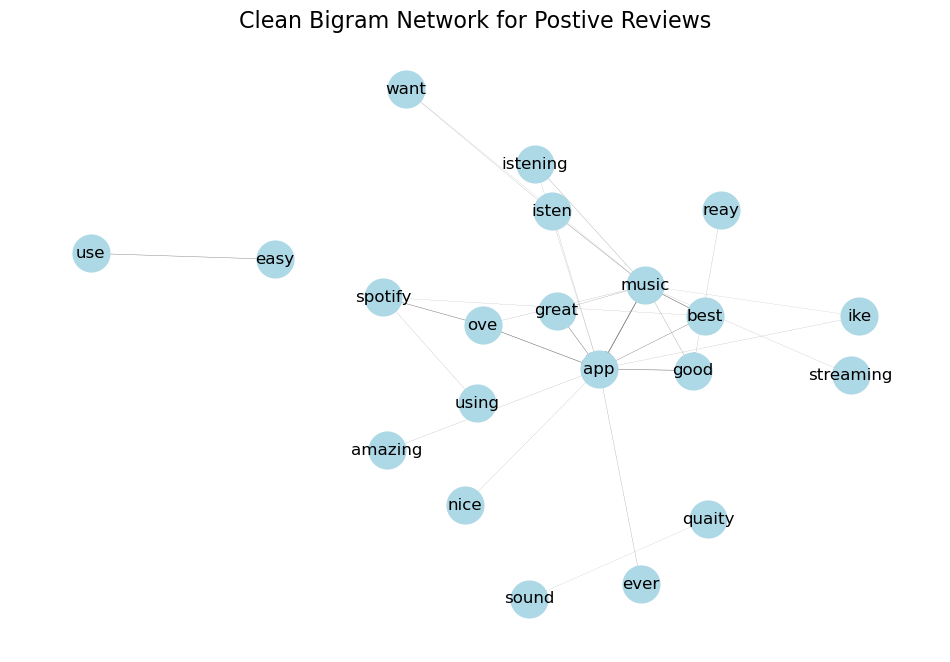

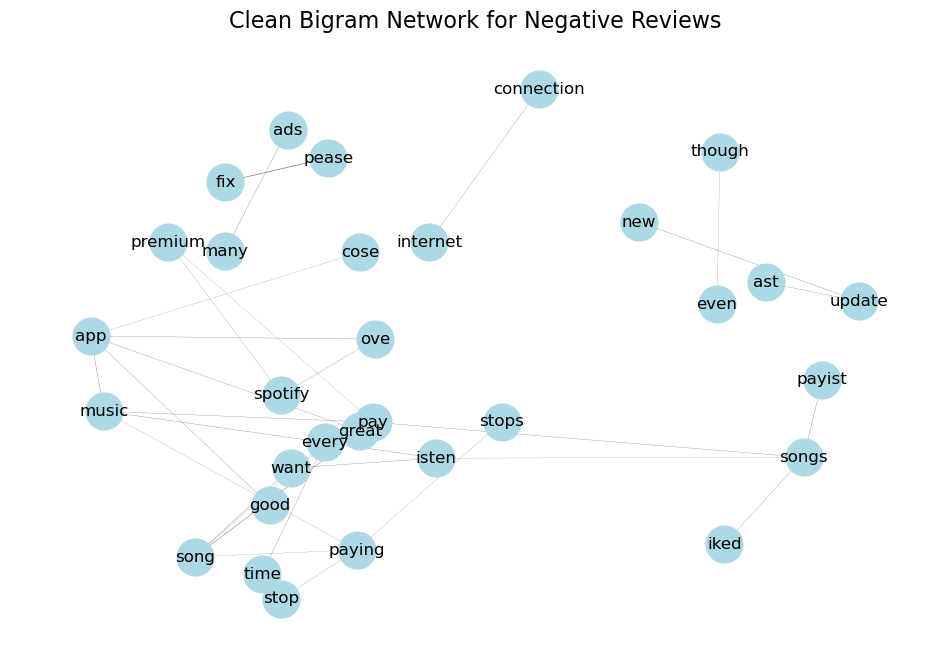

In [898]:
def create_clean_bigram_network(top_bigrams, title, freq_threshold=10, spread_factor=2.0, line_scale=0.005):
    G = nx.DiGraph()  
    for bigram, weight in top_bigrams:
        if weight > freq_threshold:  
            word1, word2 = bigram
            G.add_edge(word1, word2, weight=weight)
    pos = nx.spring_layout(G, seed=3, k=spread_factor)
    plt.figure(figsize=(12, 8))
    nx.draw_networkx_nodes(G, pos, node_size=700, node_color='lightblue')
    nx.draw_networkx_edges(
        G, pos, edgelist=G.edges(data=True), arrows=True,
        width=[d['weight'] * line_scale for _, _, d in G.edges(data=True)],
        edge_color='gray', alpha=1
    )
    nx.draw_networkx_labels(G, pos, font_size=12, font_color="black")
    plt.title(title, fontsize=16), plt.axis('off');

create_clean_bigram_network(top_30_positive_bigrams, "Clean Bigram Network for Postive Reviews", freq_threshold=8, spread_factor=3.0, line_scale=0.002)
create_clean_bigram_network(top_30_negative_bigrams, "Clean Bigram Network for Negative Reviews", freq_threshold=8, spread_factor=3.0, line_scale=0.002)

### Exercise 8
Using the tokenized words and their corresponding tf-idf scores, fit a linear support vector machine to predict whether a given review is positive or negative.

Split the data using stratified sampling, with 70% training and 30% testing;

Drop any columns with zero variance;

Fit a linear support vector machine using default values for any hyperparameters;

Calculate the model accuracy on your testing data.

In [937]:
#Will use the 1000 most common words from document frequency

,label,Review_clean
33050,NEGATIVE,usually love app seems like every single time ...
22351,POSITIVE,never experienced musical rollercoaster like o...
20426,NEGATIVE,really enjoy using app ever since new version ...
21743,NEGATIVE,app become incredibly buggy late try open podc...
19638,NEGATIVE,update time ago buttons notification always bl...
...,...,...
21478,POSITIVE,love thus wide rang music pod casts
6224,NEGATIVE,listen music app lol
46626,POSITIVE,spotify customer yrs great experience personal...
47856,NEGATIVE,thing would appreciate would better software t...


In [979]:
sort = sorted(df.items(), key = lambda x: x[1], reverse = True)[:]
uni_tokens = [word for word, freq in sort]
X = []

for d in dataset:
    #compute the term freq for that doc
    tf = defaultdict(int)
    r = ''.join([c for c in d['Review_clean'].lower() if c not in sp])
    for w in r.split():
        tf[w] += 1
    #compute tf-idf for the document (using idf we alr calc)
    tfidf = {word: tf[word] * idf.get(word, 0) for word in tf}
    vector = [tfidf.get(word, 0) for word in uni_tokens]
    X.append(vector)

In [1041]:
y = [d['label'] for d in dataset]

In [1043]:
#perform stratified train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=3
)


In [1057]:
#drop zero-variance columns
selector = VarianceThreshold(threshold=0.0)
X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

#roughly 1500 columns were dropped which should save on computational time/cost

In [1067]:
svm = SVC(kernel = 'linear', random_state = 3)
svm.fit(X_train, y_train)


SVC(kernel='linear', random_state=3)

In [1065]:
y_pred = svm.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.8177
